# Disaster messages - Part 2 - Deep learning

In an earlier __[project](https://github.com/pranath/disaster_response/blob/master/notebooks/MLPipelinePreparation.ipynb)__ I explored several conventional machine learning models in order to predict one of several categories for messages from disasters

In this project I will try to predict categories for the same messages but using one of the most advanced deep learning models for text classification available using the fastai library.

## Import libraries

In [1]:
# Import libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

## Prepare data

In [2]:
# Load data
path = Path('data')
df = pd.read_csv(path/'messages_disaster_clean.csv')
df.head()

,tags,message
0,related,Weather update - a cold front from Cuba that c...
1,related;aid_related;other_aid;weather_related;...,Is the Hurricane over or is it not over
2,related,Looking for someone but no name
3,related;request;aid_related;medical_products;o...,UN reports Leogane 80-90 destroyed. Only Hospi...
4,related,"says: west side of Haiti, rest of the country ..."


In [3]:
df.shape

(26215, 2)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26215 entries, 0 to 26214
Data columns (total 2 columns):
tags       20093 non-null object
message    26215 non-null object
dtypes: object(2)
memory usage: 409.7+ KB


## Create language model

For our deep learning classifier we are first going to create a language model. Our language model 'AWD_LSTM' will be a Recurrent neural network (RNN), that is implemented as a long short-term memory network (LSTM).

The AWD_LSTM architecture is inspired by this __[paper](https://arxiv.org/abs/1708.02182)__.

This model has been trained on several million wikipedia articles, and is able to predict the next word in a sequence given some starting words i.e. it is a pre-trained model.

We will then use the first half of this pre-trained AWD_LSTM model, fine tune it on our dataset of disaster messages, and then chop of the first part of it to use it as the feature detector/first half of our classification model.

We would hope then this gives our model a good understanding of text in general first, before being optimised for our own dataset in order to give it the best chance to classify our disaster messages correctly.

In [4]:
# Set batch size
bs = 48

In [5]:
# Create data object for our language model using whole dataset 
data_lm = (TextList.from_df(df, path, cols='message') 
                .random_split_by_pct(0.1) # Use most of dataset to train this langauge model
                .label_for_lm() # LM creates its own labels from the text
                .databunch(bs=bs))

In [6]:
# Save for quick load when returning
data_lm.save('data_lm.pkl')

In [5]:
# Load language model data
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [8]:
# Have a quick look at how our messages have been automagically pre-processed / tokenised
data_lm.show_batch()

idx,text
0,"haiti , rest of the country today and tonight xxbos xxmaj storm at xxunk heart of jesus xxbos xxmaj please , we need tents and water . xxmaj we are in xxmaj silo , xxmaj thank you ! xxbos i would like to receive the messages , thank you xxbos i am in xxmaj croix - des - xxmaj bouquets . xxmaj we have health issues . xxmaj they ("
1,", i found a large building on lamentin 54 that could be an hospital . .. please confirm . xxbos xxmaj asking for xxmaj water , xxmaj food and xxmaj tents xxbos xxmaj we need medicine for xxmaj hypertension and xxunk / pads and medicine for xxunk baby too . xxbos xxmaj need tents , water and food . xxmaj children are sick with fever . xxbos i am without"
2,"that . .. xxbos .. . zone xxmaj croix de xxmaj bouquets , i 'm asking please what i can do to get help especially a place to sleep with my children because my place . ... xxbos xxmaj hi , we are on xxmaj rte 9 , right after the xxmaj minustah xxmaj base , we have no water and food . xxmaj the way they distributed the supplies"
3,to xxmaj digicel xxmaj organisation of young victims sou ray ( name of the main road closest to the sea in xxmaj carrefour . xxmaj we are a bunch of people who are victims of the catastrophe of xxmaj tuesday xxmaj january 12 xxbos xxmaj message important asking whether xxmaj haiti is under occupation xxbos i am from xxmaj port - au - xxmaj prince in the west . xxmaj
4,"all in my area . xxbos xxmaj the hunger is killing us do something for us in xxmaj l'acul , xxmaj leogane xxbos you will never get hurt or xxunk in distribution of food in cite soleil xxbos xxmaj my family is in xxmaj delmas 14 and needs some aid . xxmaj they need food , water , and shelter . xxmaj my cousin has an infant who needs baby"


In [9]:
# Create pre-trained language model AWD_LSTM with our data
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


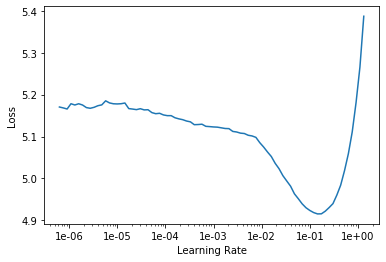

In [10]:
# Find optimal learning rates
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=10)

In [11]:
# Fit the last layers
learn_lm.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.947898,3.717568,0.325702,00:38


In [12]:
# Save language model for quicker start when returning
learn_lm.save('fit_head')

In [13]:
# Load language model from this point
learn_lm.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (23594 items)
x: LMTextList
xxbos xxmaj weather update - a cold front from xxmaj cuba that could pass over xxmaj haiti,xxbos xxmaj is the xxmaj hurricane over or is it not over,xxbos xxmaj looking for someone but no name,xxbos xxup un reports xxmaj leogane 80 - 90 destroyed . xxmaj only xxmaj hospital xxmaj st. xxmaj croix functioning . xxmaj needs supplies desperately .,xxbos says : west side of xxmaj haiti , rest of the country today and tonight
y: LMLabelList
,,,,
Path: data;

Valid: LabelList (2621 items)
x: LMTextList
xxbos xxmaj back in xxmaj santiago from traveling the s of xxmaj chile in 2 days . xxunk traveled & visited 5 cities giving supplies .. xxmaj it 's amazing what you see !,xxbos willing to help in any way i can ; i do n't own a car but can drive and pack and xxunk and carry items . xxmaj can help with info , preparing food , etc .,xxbos xxmaj it was the only available but rather difficult option in the wake of ha

In [14]:
# Unfreeze other layers and train some more
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.503204,3.571204,0.341560,00:50
1,3.378392,3.490188,0.349952,00:51
2,3.097170,3.456255,0.357571,00:52
3,2.781008,3.477144,0.357262,00:52
4,2.577574,3.506318,0.356274,00:52


The accuracy here is a measure of how well the model predicts the next word of all of the words in our messages, at around 35% accuracy our model is doing quite well!

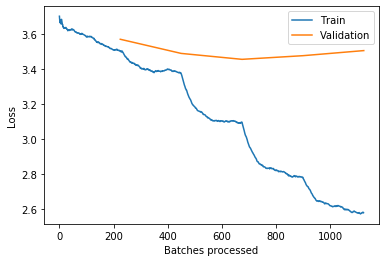

In [15]:
# Plot train v validation loss
learn_lm.recorder.plot_losses()

In [16]:
# Save our optimised model
learn_lm.save('fine_tuned')

In [17]:
# Save the first half of our model, the encoder - to use with our classifier
learn_lm.save_encoder('fine_tuned_enc')

The encoder is the first part of the language model, this is the part concerned with understanding the text so far (as opposed to the last part which aims to predict the next word). 

This is why we save the encoder, as it could most likely be useful for our classifier.

## Create classifier model

We will now create our message clasifier, making use of the encoder from our language model.

In [6]:
# Set batch size
bs = 24

In [7]:
# Define precison for our purposes
def precision(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()

In [8]:
# Define recall for our purposes
def recall(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

In [9]:
# Split data into train and validation
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['tags'], random_state=49)
df_trn = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_test, y_test], axis=1)

In [10]:
# Check for missing values
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19661 entries, 18830 to 426
Data columns (total 2 columns):
message    19661 non-null object
tags       15088 non-null object
dtypes: object(2)
memory usage: 460.8+ KB


In [11]:
# Check for missing values
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6554 entries, 7603 to 21079
Data columns (total 2 columns):
message    6554 non-null object
tags       5005 non-null object
dtypes: object(2)
memory usage: 153.6+ KB


In [12]:
# Drop missing values from train and validation sets
df_trn = df_trn.dropna()
df_val = df_val.dropna()

In [13]:
# Create data object for our classifier with specific train & validation sets
data_clas = TextClasDataBunch.from_df(path, train_df=df_trn, valid_df=df_val, 
                                  vocab=data_lm.vocab, # Use same vocab from our language model
                                  text_cols='message', 
                                  label_cols='tags',
                                  label_delim=';',
                                  bs=bs)

In [14]:
# Save our data object
data_clas.save('tmp_clas')

In [15]:
# Create our classifier model
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# Define metrics for training
learn.metrics = [accuracy_thresh, precision, recall]
# Load in the encoder of our language model
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15088 items)
x: TextList
xxbos xxmaj photos on xxmaj china xxmaj news xxmaj service showed people in xxmaj fujian 's xxmaj xxunk county wearing xxunk and xxunk deep in water through flooded streets .,xxbos xxup ocha says a series of short - term measures need to be taken to improve conditions for the farmers , including the repair and maintenance of xxunk plants , the installation of manual pumps and increased capacity for stocking and treating water .,xxbos xxmaj seasonal downpours cause dozens of landslides and flash floods each year in xxmaj indonesia , where millions of people live in mountainous regions and near fertile flood plains close to rivers .,xxbos xxmaj in xxmaj xxunk , about 8 kms from xxmaj xxunk , at least 20 people drowned including a xxunk as a rescue boat capsized due to uncontrolled crowd and over loading .,xxbos xxmaj authorities have also rushed 180 medical teams comprising more than 1,000 doctors amid fears t

In [55]:
# Lets freeze the model so we start training the classifier on only the last layers
learn.freeze()
# Train the model
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,precision,recall,time
0,0.201225,0.180335,0.934117,0.888722,0.492152,00:24


In [56]:
# Save model at this point
learn.save('first_factors')

In [23]:
# Load model at this point
learn.load('first_factors')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15088 items)
x: TextList
xxbos xxmaj photos on xxmaj china xxmaj news xxmaj service showed people in xxmaj fujian 's xxmaj xxunk county wearing xxunk and xxunk deep in water through flooded streets .,xxbos xxup ocha says a series of short - term measures need to be taken to improve conditions for the farmers , including the repair and maintenance of xxunk plants , the installation of manual pumps and increased capacity for stocking and treating water .,xxbos xxmaj seasonal downpours cause dozens of landslides and flash floods each year in xxmaj indonesia , where millions of people live in mountainous regions and near fertile flood plains close to rivers .,xxbos xxmaj in xxmaj xxunk , about 8 kms from xxmaj xxunk , at least 20 people drowned including a xxunk as a rescue boat capsized due to uncontrolled crowd and over loading .,xxbos xxmaj authorities have also rushed 180 medical teams comprising more than 1,000 doctors amid fears t

In [24]:
# Unfreeze last 2 layers, not whole model (works better than total unfreeze for text models)
learn.freeze_to(-2)
# Train some more
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7), wd=0.1)
# Note 2.6**4! This seems to work well from text classification RNN models from experimentation by JH
# Related: Some have used random forrest models to find most optimal hyper params like lr

epoch,train_loss,valid_loss,accuracy_thresh,precision,recall,time
0,0.186708,0.170866,0.939718,0.879542,0.563686,00:38
1,0.175495,0.161384,0.943126,0.891711,0.582238,00:40


In [ ]:
# Save model at this point
learn.save('second_factors')

In [16]:
# Load model at this point
learn.load('second_factors')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15088 items)
x: TextList
xxbos xxmaj photos on xxmaj china xxmaj news xxmaj service showed people in xxmaj fujian 's xxmaj xxunk county wearing xxunk and xxunk deep in water through flooded streets .,xxbos xxup ocha says a series of short - term measures need to be taken to improve conditions for the farmers , including the repair and maintenance of xxunk plants , the installation of manual pumps and increased capacity for stocking and treating water .,xxbos xxmaj seasonal downpours cause dozens of landslides and flash floods each year in xxmaj indonesia , where millions of people live in mountainous regions and near fertile flood plains close to rivers .,xxbos xxmaj in xxmaj xxunk , about 8 kms from xxmaj xxunk , at least 20 people drowned including a xxunk as a rescue boat capsized due to uncontrolled crowd and over loading .,xxbos xxmaj authorities have also rushed 180 medical teams comprising more than 1,000 doctors amid fears t

In [17]:
# Unfreeze whole model
learn.unfreeze()
# Train some more
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,precision,recall,time
0,0.162541,0.156966,0.945878,0.874520,0.632789,01:12
1,0.164536,0.155622,0.946152,0.881230,0.622061,01:11


In [18]:
# Predict on the validation dataset
y_pred, y_true =  learn.get_preds()

## Evaluate results

In [19]:
# Get overall F1 score for predicting all classes
f1_score(y_true, y_pred>0.35, average='micro')

0.7499250374812594

So in my earlier study our best overall F1 score was 0.41, 0.75 is a significant improvement!

In [20]:
# Get numeric values
y_true = y_true.numpy()
scores = y_pred.numpy()

In [21]:
# Check dimensions
scores.shape, y_true.shape

((5005, 35), (5005, 35))

In [22]:
# Print metrics for different classes predicted
metrics = classification_report(y_true, scores>0.35, target_names=data_clas.valid_ds.classes)
print(metrics)

                        precision    recall  f1-score   support

           aid_centers       0.20      0.04      0.07        76
           aid_related       0.69      0.90      0.78      2704
             buildings       0.68      0.58      0.62       327
              clothing       0.49      0.44      0.47        79
                  cold       0.73      0.40      0.52       148
                 death       0.76      0.52      0.62       304
         direct_report       0.64      0.74      0.68      1251
            earthquake       0.84      0.82      0.83       569
           electricity       0.62      0.50      0.55       131
                  fire       0.67      0.06      0.12        63
                floods       0.71      0.63      0.67       550
                  food       0.78      0.86      0.82       711
             hospitals       0.50      0.07      0.13        67
infrastructure_related       0.43      0.18      0.26       428
          medical_help       0.59      

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In the earlier study we looked at the top 12 predicted classes for our best model (Gradient Boosting), lets compare the results for these with our new deep learning model.


| Category | Gradient Boosting - F1 | AWD_LSTM - F1|
| --- | --- | --- |
|earthquake | 0.79 | 0.83 |
|food|0.76|0.82|
|weather_related|0.71|0.83|
|water|0.68|0.77|
|floods|0.66|0.67|
|shelter|0.64|0.69|
|aid_related|0.64|0.78|
|storm|0.61|0.69|
|clothing|0.60|0.47|
|cold|0.59|0.52|
|request|0.55|0.74|
|death|0.54|0.62|
|direct_report|0.51|0.68|

We can see the AWD_LSTM has a better score in most of these categories, as well as better scores overall on average.

## Conclusion 

The deep learning model classifier AWD_LSTM seems to have made better predictions overall than the best of our previous model.